## Load Data

In [5]:
import torch, torchvision

train_set = torchvision.datasets.FashionMNIST("./data", download=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)
X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_train = X_train/255.0
X_test = X_test/255.0

In [6]:
X_train.shape

(60000, 784)

## KNN Classifier

In [11]:
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class KNNModel:
    def __init__(self):
        self.best_knn = None
        self.grid_search = None

        
    def fit(self, X_train, y_train, param_grid):
        knn = KNeighborsClassifier()
        self.grid_search = GridSearchCV(knn, param_grid, cv=5)
        self.grid_search.fit(X_train, y_train)
        self.best_knn = self.grid_search.best_estimator_
        
        k_values = None
        k_parameter_pattern = re.compile(r'n[_]?neighbors|k[_]?values', re.IGNORECASE)
        for key, value in param_grid.items():
            if isinstance(value, list) and k_parameter_pattern.search(key):
                k_values = value
                break
        
        if k_values is None:
            raise ValueError("K-values not found in param_grid")
        
        # compute the accuracy score for each hyperparameter combination
        cv_results = self.grid_search.cv_results_
        test_scores_mean = cv_results['mean_test_score']
        test_scores_stds = cv_results['std_test_score']
        for mean, std, params in zip(test_scores_mean, test_scores_stds, cv_results['params']):
            print(f"Accuracy: {mean:.3f} (±{std*2:.3f}) for {params}")

        # Display average accuracy for each hyperparameter combination
        results_df = pd.DataFrame(cv_results)
        results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
        param_cols = ['param_' + key for key in param_grid.keys()]
        mean_test_score_col = 'mean_test_score'
        print(results_df_sorted[param_cols + [mean_test_score_col]])

        # print the best hyperparameters
        best_params = self.grid_search.best_params_
        print("Best Hyperparameters:", best_params)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, 1 - test_scores_mean, label='Training Error')
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(1-test_scores_mean)
        print(f"The number of nearest neighbors (k) associated with the smallest training error is {k_values[min_cv_k]}")
          # Print training accuracy
        train_accuracy = self.best_knn.score(X_train, y_train)
        print(f"Training Accuracy: {train_accuracy}")

        
    def evaluate(self, X_test, y_test):
        if self.best_knn is None:
            raise ValueError("Fit the model before evaluating")
        
        test_accuracy = self.best_knn.score(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy}")
        
        knn_predictions = self.best_knn.predict(X_test)
        
        print("KNN Classification Report:")
        print(classification_report(y_test, knn_predictions))
        
        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, knn_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('KNN Confusion Matrix')
        plt.show()

        #probability estimates for positive class
        y_probs = self.best_knn.predict_proba(X_test)
        # Compute ROC curve and ROC area for each class
        n_classes = len(self.best_knn.classes_)
        plt.figure(figsize=(8, 8))
        if n_classes > 2:
            for i in range(n_classes):
                fpr, tpr, thresholds = roc_curve(y_test == i, y_probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i} vs the rest) (AUC = {roc_auc:.2f})')
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def kfold_cv(self, X_train, y_train, X_test, y_test, k_values):
        training_errors = []
        cv_errors_list = []
        avg_cv_errors = []
        test_errors = []

        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)

            training_error = 1 - knn.score(X_train, y_train)
            cv_errors = cross_val_score(knn, X_train, y_train, cv=5)
            avg_cv_error = 1 - np.mean(cv_errors)
            test_error = 1 - knn.score(X_test, y_test)

            training_errors.append(training_error)
            test_errors.append(test_error)
            avg_cv_errors.append(avg_cv_error)
            cv_errors_list.append(cv_errors)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, training_errors, label='Training Error')
        plt.plot(k_values, test_errors, label='Test Error')
        plt.plot(k_values, avg_cv_errors, label='CV Error')
        #plt.errorbar(k_values, avg_cv_errors, yerr=np.std(avg_cv_errors), label='CV Error', c='green', marker='o', capsize=5)
        #plt.errorbar(k_values, avg_cv_errors, yerr=[np.std(errors) for errors in cv_errors_list], label='CV Error', c='green', marker='o', capsize=5)
        
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(avg_cv_errors)
        min_test_k = np.argmin(test_errors)
        print(f"The number of nearest neighbors (k) with the smallest cross-validation error is {k_values[min_cv_k]} and an error of {avg_cv_errors[min_cv_k]}")
        print(f"The number of nearest neighbors (k) with the smallest test error is {k_values[min_test_k]} and an error of {test_errors[min_test_k]}")
        
    def bootstrap(self, X_train, y_train, n_bootstrap, k_folds=5):
        
        bootstrap_accuracy_list = []
        for b in range(n_bootstrap):
            resampled_X_train, resampled_y_train = resample(X_train, y_train, replace=True, random_state=b)
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=b)

            fold_accuracy_list = []
            for train_index, val_index in kf.split(resampled_X_train):
                X_train_fold, X_val_fold = resampled_X_train[train_index], resampled_X_train[val_index]
                y_train_fold, y_val_fold = resampled_y_train[train_index], resampled_y_train[val_index]

                self.best_knn.fit(X_train_fold, y_train_fold)
                fold_accuracy = self.best_knn.score(X_val_fold, y_val_fold)
                fold_accuracy_list.append(fold_accuracy)

            bootstrap_accuracy = np.mean(fold_accuracy_list)
            bootstrap_accuracy_list.append(bootstrap_accuracy)

        # Calculate the 5th and 95th percentiles
        mean_acc = np.mean(bootstrap_accuracy_list)
        percentile_5 = np.percentile(bootstrap_accuracy_list, 5)
        percentile_95 = np.percentile(bootstrap_accuracy_list, 95)
        print("Mean accuracy: ", mean_acc)
        print(f"5th percentile of accuracy: {percentile_5}")
        print(f"95th percentile of accuracy: {percentile_95}")

        

## PCA

Number of components explaining 95% variance: 256
Cumulative explained variance ratio:  0.9501636227579313


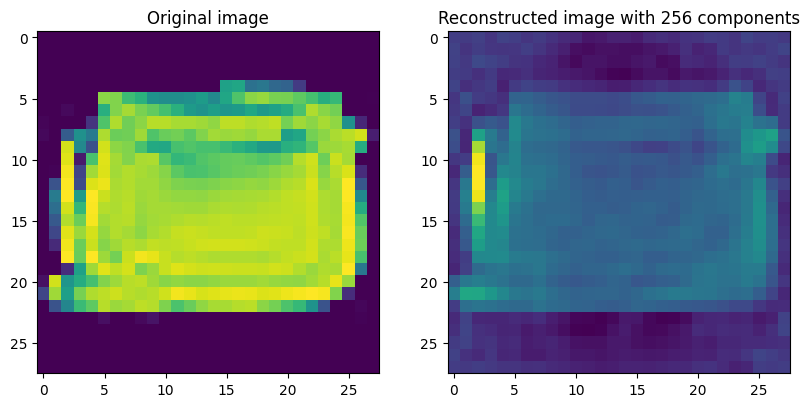

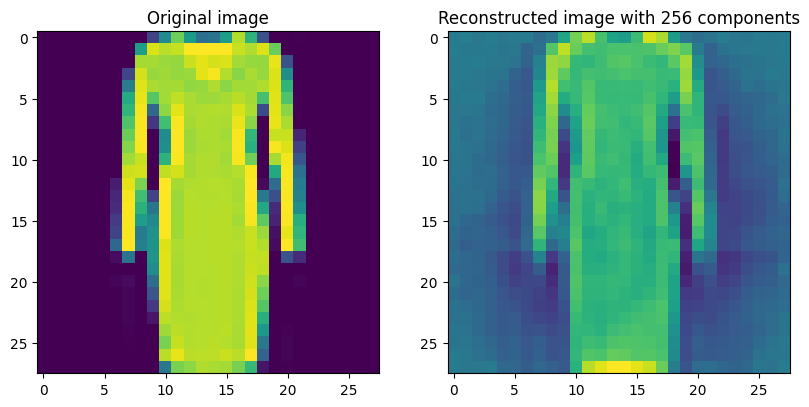

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Get the number of components that explain 95% of variance
p_components = pca.n_components_
print(f"Number of components explaining 95% variance: {p_components}")
# print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio: ", np.sum(pca.explained_variance_ratio_))

n = X_train.shape[0]
np.random.seed(20)
random_indices = np.random.randint(1, n + 1, 2)


for i in random_indices:
    plt.figure(figsize=(15, 20))

    plt.subplot(131)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.title('Original image')
    
    reconstructed_img = pca.inverse_transform(X_train_pca[i]).reshape(28, 28)
    plt.subplot(132)
    plt.imshow(reconstructed_img)
    plt.title(f'Reconstructed image with {p_components} components')
    plt.show()



## Base KNN with scaled data

Accuracy: 0.848 (±0.004) for {'n_neighbors': 1}
Accuracy: 0.846 (±0.006) for {'n_neighbors': 2}
Accuracy: 0.853 (±0.009) for {'n_neighbors': 3}
Accuracy: 0.857 (±0.009) for {'n_neighbors': 4}
Accuracy: 0.855 (±0.005) for {'n_neighbors': 5}
Accuracy: 0.856 (±0.005) for {'n_neighbors': 6}
Accuracy: 0.854 (±0.006) for {'n_neighbors': 7}
Accuracy: 0.855 (±0.006) for {'n_neighbors': 8}
Accuracy: 0.853 (±0.006) for {'n_neighbors': 9}
Accuracy: 0.853 (±0.005) for {'n_neighbors': 10}
Accuracy: 0.852 (±0.006) for {'n_neighbors': 11}
Accuracy: 0.851 (±0.006) for {'n_neighbors': 12}
Accuracy: 0.850 (±0.005) for {'n_neighbors': 13}
Accuracy: 0.850 (±0.006) for {'n_neighbors': 14}
Accuracy: 0.848 (±0.007) for {'n_neighbors': 15}
Accuracy: 0.847 (±0.006) for {'n_neighbors': 16}
Accuracy: 0.847 (±0.006) for {'n_neighbors': 17}
Accuracy: 0.846 (±0.006) for {'n_neighbors': 18}
Accuracy: 0.845 (±0.005) for {'n_neighbors': 19}
Accuracy: 0.845 (±0.006) for {'n_neighbors': 20}
Accuracy: 0.844 (±0.006) for 

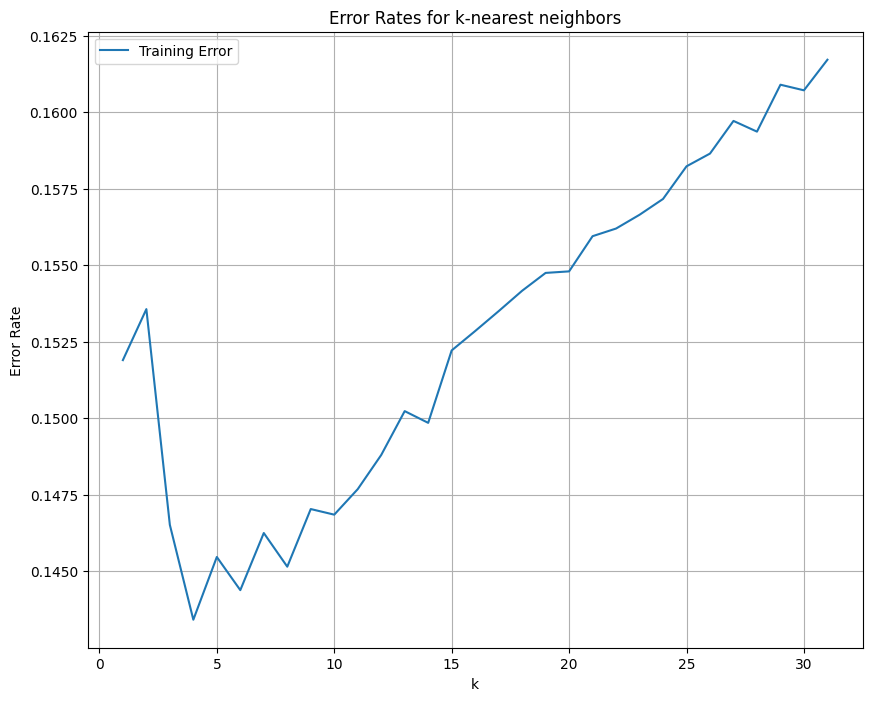

The number of nearest neighbors (k) associated with the smallest training error is 4
Training Accuracy: 0.91095


In [9]:
#Base KNN model
knn_model = KNNModel()
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
param_grid = {'n_neighbors': list(range(1, 32))}
knn_model.fit(X_train_scaled, y_train, param_grid)


Test Accuracy: 0.8543
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1000
           1       0.99      0.97      0.98      1000
           2       0.74      0.82      0.78      1000
           3       0.90      0.86      0.88      1000
           4       0.78      0.75      0.77      1000
           5       0.99      0.88      0.93      1000
           6       0.64      0.55      0.59      1000
           7       0.89      0.97      0.92      1000
           8       0.98      0.93      0.95      1000
           9       0.92      0.95      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



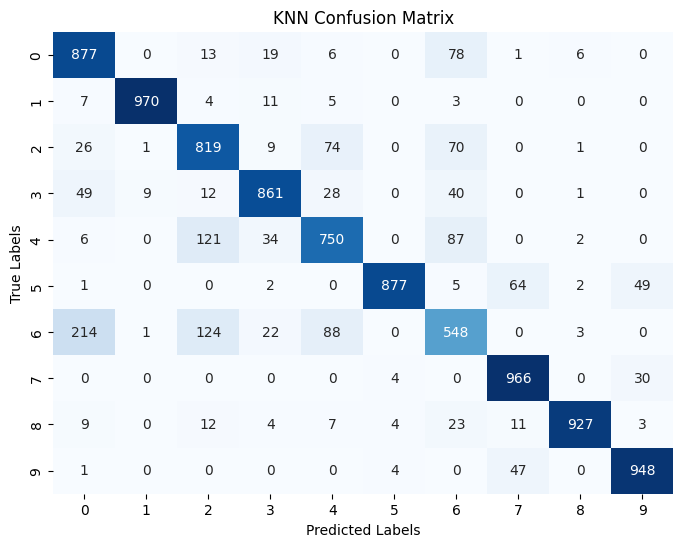

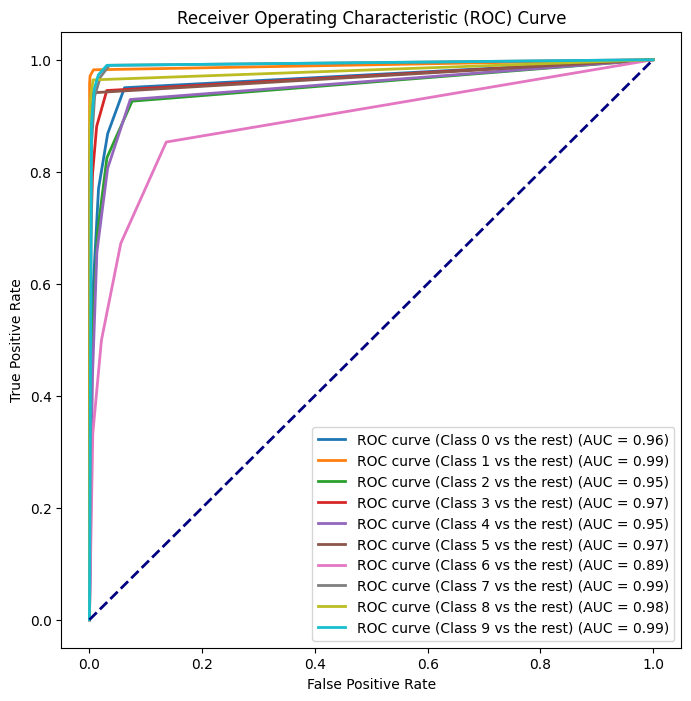

In [10]:
knn_model.evaluate(X_test_scaled, y_test)

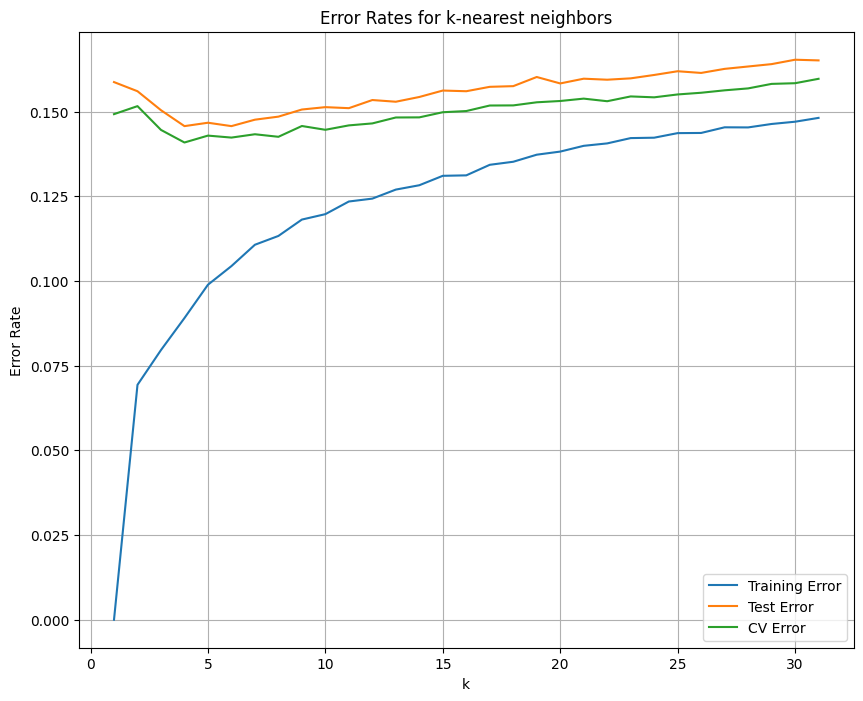

The number of nearest neighbors (k) with the smallest cross-validation error is 4 and an error of 0.1408666666666667
The number of nearest neighbors (k) with the smallest test error is 4 and an error of 0.14570000000000005


In [12]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
knn_model.kfold_cv(X_train_scaled, y_train, X_test_scaled, y_test, param_grid['n_neighbors'])

## PCA + KNN

Accuracy: 0.852 (±0.004) for {'n_neighbors': 1}
Accuracy: 0.849 (±0.003) for {'n_neighbors': 2}
Accuracy: 0.859 (±0.008) for {'n_neighbors': 3}
Accuracy: 0.862 (±0.007) for {'n_neighbors': 4}
Accuracy: 0.863 (±0.007) for {'n_neighbors': 5}
Accuracy: 0.863 (±0.006) for {'n_neighbors': 6}
Accuracy: 0.861 (±0.006) for {'n_neighbors': 7}
Accuracy: 0.862 (±0.003) for {'n_neighbors': 8}
Accuracy: 0.861 (±0.006) for {'n_neighbors': 9}
Accuracy: 0.861 (±0.006) for {'n_neighbors': 10}
Accuracy: 0.861 (±0.006) for {'n_neighbors': 11}
Accuracy: 0.860 (±0.006) for {'n_neighbors': 12}
Accuracy: 0.859 (±0.007) for {'n_neighbors': 13}
Accuracy: 0.859 (±0.005) for {'n_neighbors': 14}
Accuracy: 0.857 (±0.006) for {'n_neighbors': 15}
Accuracy: 0.858 (±0.007) for {'n_neighbors': 16}
Accuracy: 0.856 (±0.006) for {'n_neighbors': 17}
Accuracy: 0.856 (±0.007) for {'n_neighbors': 18}
Accuracy: 0.856 (±0.007) for {'n_neighbors': 19}
Accuracy: 0.855 (±0.006) for {'n_neighbors': 20}
Accuracy: 0.854 (±0.005) for 

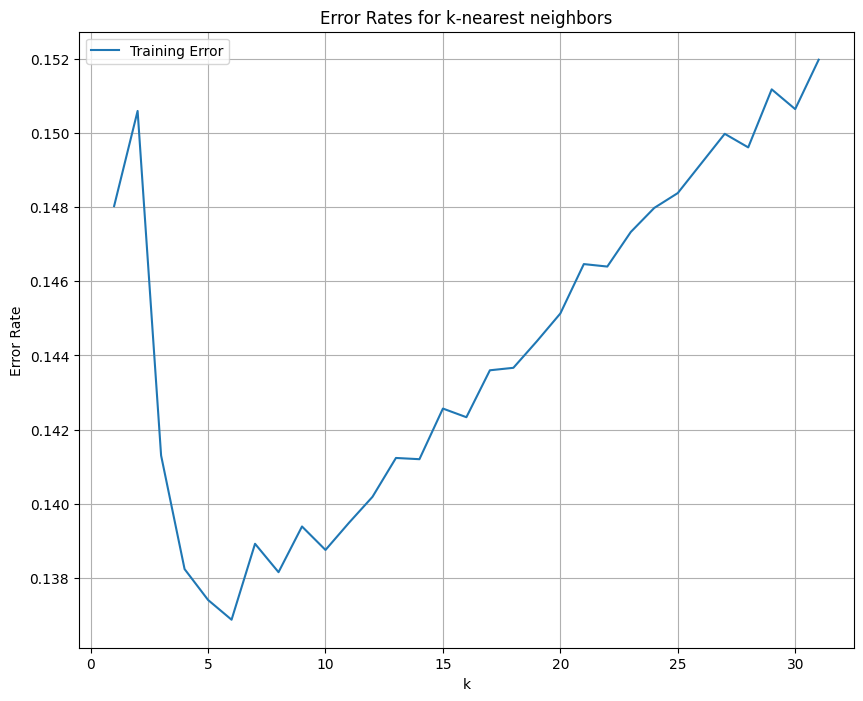

The number of nearest neighbors (k) associated with the smallest training error is 6
Training Accuracy: 0.9012833333333333


In [13]:
#PCA + KNN
knn_pca_model = KNNModel()
param_grid = {'n_neighbors': list(range(1, 32))}
knn_pca_model.fit(X_train_pca, y_train, param_grid)

Test Accuracy: 0.8611
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.75      0.80      0.77      1000
           3       0.89      0.88      0.88      1000
           4       0.77      0.77      0.77      1000
           5       0.98      0.89      0.93      1000
           6       0.67      0.58      0.62      1000
           7       0.90      0.96      0.93      1000
           8       0.98      0.93      0.96      1000
           9       0.92      0.95      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



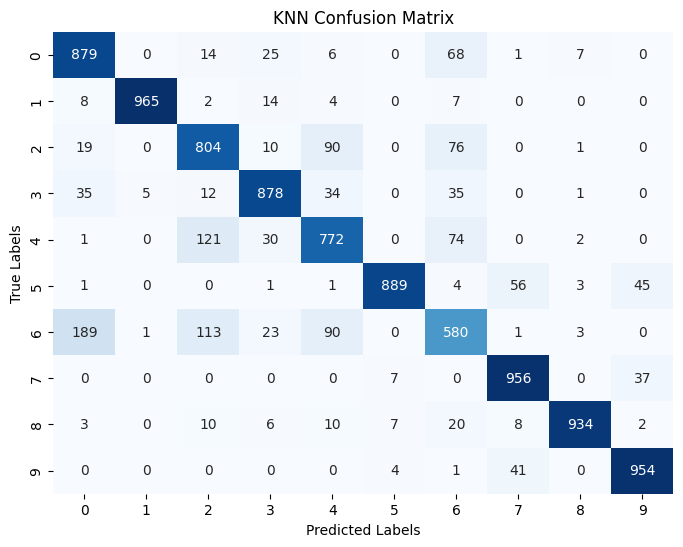

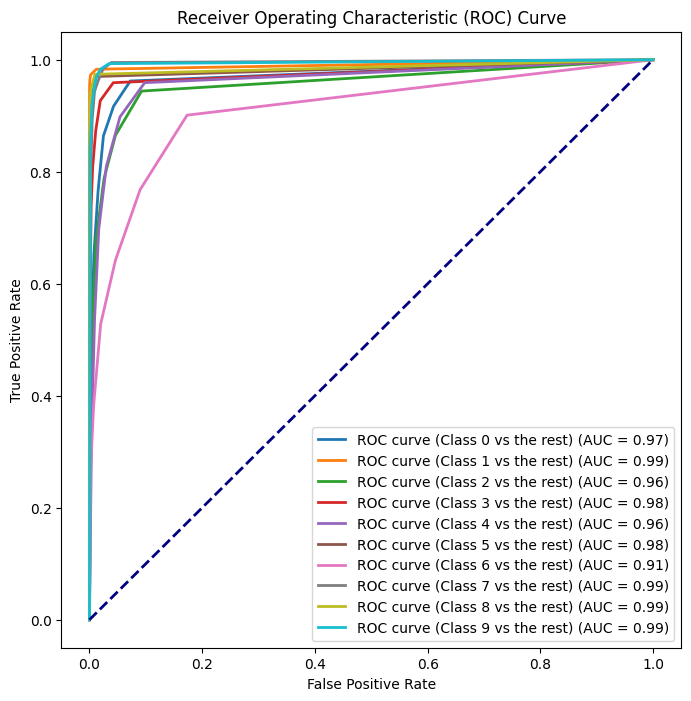

In [14]:
knn_pca_model.evaluate(X_test_pca, y_test)

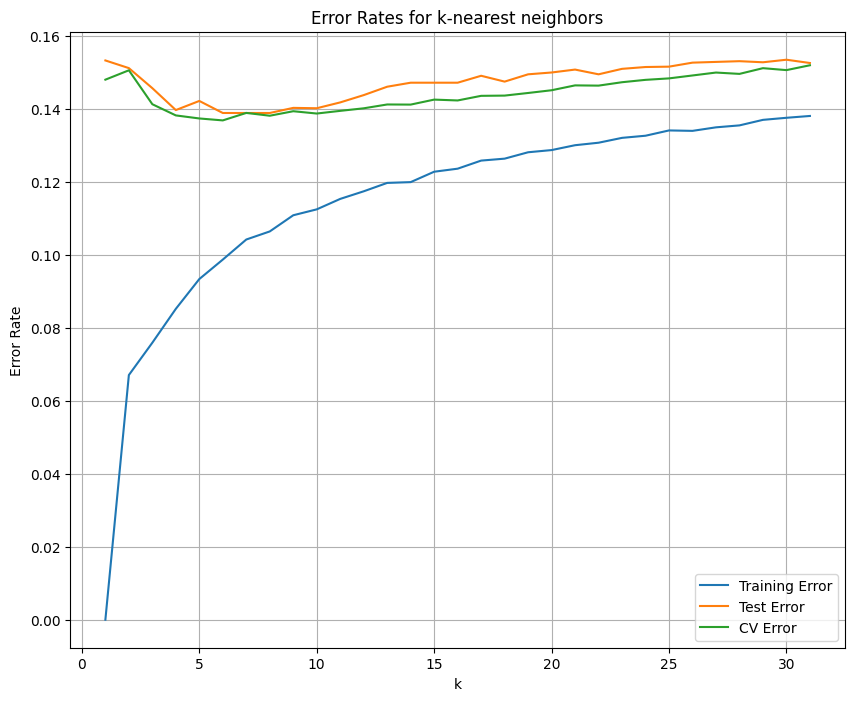

The number of nearest neighbors (k) with the smallest cross-validation error is 6 and an error of 0.13686666666666658
The number of nearest neighbors (k) with the smallest test error is 6 and an error of 0.13890000000000002


In [15]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
knn_pca_model.kfold_cv(X_train_pca, y_train, X_test_pca, y_test, param_grid['n_neighbors'])